In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import xarray as xr

In this notebook we will show how to do multiprocessing on a "real life" example using `qutip`.

## Influence of spin bath on electron Ramsey

In this notebook we are going to simulate the Ramsey signal from an electron spin, where the precession frequency is slightly different for each experiment because of a nuclear spin bath. The nuclear spin bath varies slowly, which means that frequency is stable within a single experiment.

Loosly based on https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/time-evolution/003_qubit-dynamics.ipynb

For this we first want to have a function that can simulate the signal over time of a single experiment for a given detuning of the precession frequency compared to a rotation frame.

In [2]:
def ramsey(time_array_s, detuning_hz=0):
    H = detuning_hz * 2 * np.pi * qt.sigmaz() / 2.0
    initial_state = 1 / np.sqrt(2) * (qt.basis(2, 0) + qt.basis(2, 1))
    result = qt.mesolve(H, initial_state, time_array_s, e_ops=[qt.sigmax()])
    sigma_x_timetrace = result.expect[0]
    return sigma_x_timetrace

Let's first test that our function works as expected:

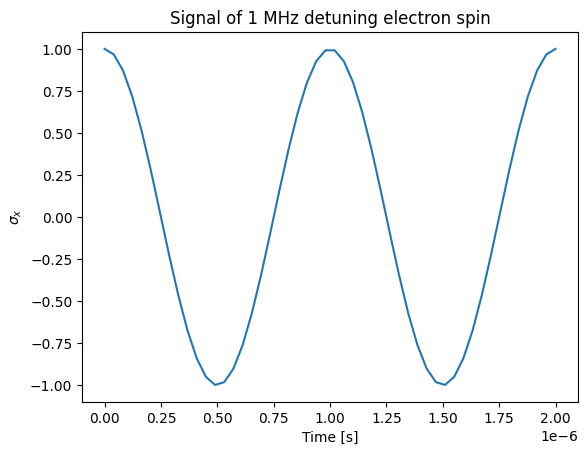

In [3]:
time_array_s = np.linspace(0, 2e-6)
sigma_x = ramsey(time_array_s, 1e6)
plt.plot(time_array_s, sigma_x)
plt.title("Signal of 1 MHz detuning electron spin")
plt.xlabel("Time [s]")
plt.ylabel(r"$\sigma_x$");

To make our notebooks cleaner and our precious simulation function reusable we move the function into our own library: `src/simulation_tutorial/lib.py`

In [4]:
from simulation_tutorial import lib

lib.ramsey

<function simulation_tutorial.lib.ramsey(time_array_s, detuning_hz=0)>

# Using apply_ufunc

Let's setup the same analysis in `xarray` so that we can easily sweep variables.

In [5]:
US_TO_S = 1e-6
MHZ_TO_HZ = 1e6

In [6]:
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds["detuning_MHz"] = 1
ds.detuning_MHz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_Hz"] = ds.detuning_MHz * MHZ_TO_HZ
ds["sigma_x"] = xr.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_Hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True
)
ds.sigma_x.attrs = {"long_name": r"$\sigma_x$"}
ds

<xarray.Dataset> Size: 2kB
Dimensions:       (time_us: 100)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_MHz  int64 8B 1
    detuning_Hz   float64 8B 1e+06
    sigma_x       (time_us) float64 800B 1.0 0.992 0.9679 ... 0.9679 0.992 1.0

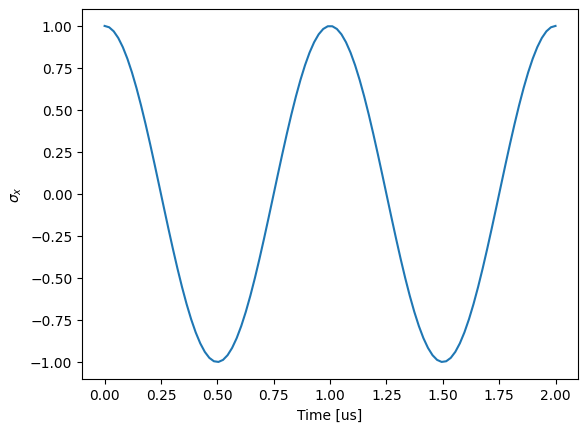

In [7]:
ds.sigma_x.plot()

## How would a fluctuation bath show up in a Ramsey measurement

In [8]:
GAUSSIAN_FWHM_TO_SIGMA = 1/ (2 * np.sqrt(2 * np.log(2))) # https://en.wikipedia.org/wiki/Full_width_at_half_maximum

In [9]:
mc_size = 1000
detuning_MHz_mean = 0
detuning_MHz_FWHM = 0.5
detuning_MHz_sigma = detuning_MHz_FWHM * GAUSSIAN_FWHM_TO_SIGMA
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds["detuning_MHz"] = xr.DataArray(np.random.normal(
    detuning_MHz_mean, 
    detuning_MHz_sigma, 
    mc_size
    ), dims='mc')
ds.detuning_MHz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_Hz"] = ds.detuning_MHz * MHZ_TO_HZ
ds["sigma_x"] = xr.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_Hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True
)
ds.sigma_x.attrs = {"long_name": r"$\sigma_x$"}
ds


<xarray.Dataset> Size: 818kB
Dimensions:       (time_us: 100, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_MHz  (mc) float64 8kB -0.04317 -0.1079 0.05085 ... 0.1686 0.07259
    detuning_Hz   (mc) float64 8kB -4.317e+04 -1.079e+05 ... 1.686e+05 7.259e+04
    sigma_x       (mc, time_us) float64 800kB 1.0 1.0 0.9999 ... 0.6193 0.612

Let's inspect the result of the simulations by plotting the first 10 realizations.

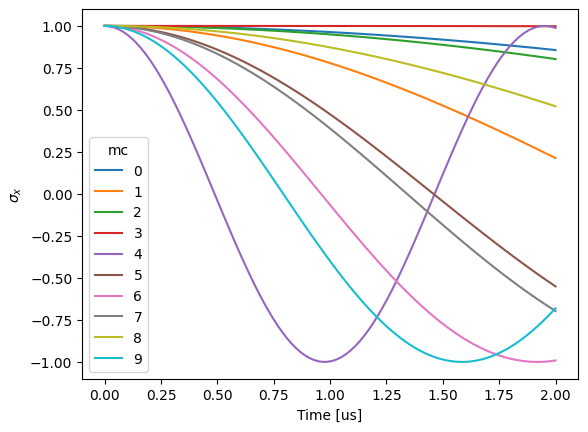

In [10]:
ds.sigma_x.isel(mc=slice(0,10)).plot(hue='mc');

We can now take the average over the 'mc' dimension to get the expectation value of $\sigma_x$.

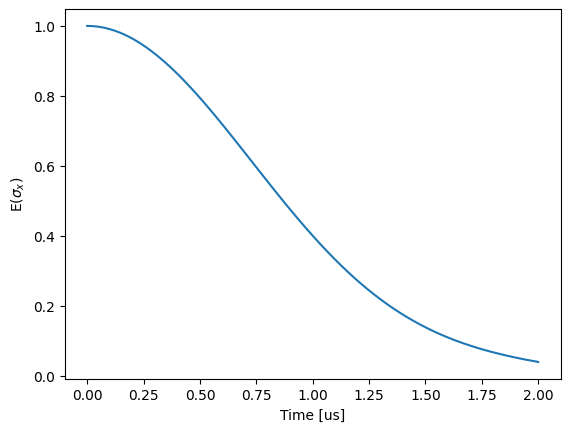

In [11]:
ds['sigma_x_mean'] = ds.sigma_x.mean("mc")
ds.sigma_x_mean.attrs = {"long_name": r"E($\sigma_x$)"}
ds.sigma_x_mean.plot();

## Now lets use multiprocessing

To speed this up we can use multiprocessing. For this I wrote a wrapper around apply_ufunc, which has the same functionality but on top accepts an argument `multiprocessing=True`. This only works when `vectorize=True` as it distributes the separate function calls over all processors. Without vectorizing there is only a single function call and this is usually much faster anyway. If you need it anyway use `dask`, see later in this notebook.

The number of function calls given to a processor at once can be set with the argument `chunksize`.

In [12]:
from simulation_tutorial import xarray_mods as xrmod

In [13]:
mc_size = 1000
detuning_MHz_mean = 0
detuning_MHz_FWHM = 0.5
detuning_MHz_sigma = detuning_MHz_FWHM * GAUSSIAN_FWHM_TO_SIGMA
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds["detuning_Mhz"] = xr.DataArray(np.random.normal(
    detuning_MHz_mean, 
    detuning_MHz_sigma, 
    mc_size
    ), dims='mc')
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sigma_x"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    multiprocessing=True,
    chunksize=50
)
ds.sigma_x.attrs = {"long_name": r"$\sigma_x$"}
ds["sigma_x_exp"] = ds.sigma_x.mean("mc")
ds.sigma_x_exp.attrs = {"long_name": r"$\sigma_x$"}
ds

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 875.37it/s]


<xarray.Dataset> Size: 818kB
Dimensions:       (time_us: 100, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (mc) float64 8kB 0.3833 0.1409 0.08915 ... -0.09948 0.09533
    detuning_hz   (mc) float64 8kB 3.833e+05 1.409e+05 ... -9.948e+04 9.533e+04
    sigma_x       (mc, time_us) float64 800kB 1.0 0.9988 ... 0.3272 0.3152
    sigma_x_exp   (time_us) float64 800B 1.0 0.9996 0.9985 ... 0.01726 0.01519

# Double sweep

Let's now sweep the detuning FWHM as well to understand its effect.

In [14]:
mc_size = 1000
detuning_MHz_mean = 0
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds['detuning_MHz_FWHM'] = np.arange(0.2, 0.71, 0.1)
ds.detuning_MHz_FWHM.attrs = {"long_name": "FWHM", "units": "MHz"}
ds['detuning_MHz_sigma'] = ds.detuning_MHz_FWHM * GAUSSIAN_FWHM_TO_SIGMA
ds["detuning_Mhz"] = xr.apply_ufunc(
    np.random.normal,
    detuning_MHz_mean, 
    ds.detuning_MHz_sigma,
    mc_size,
    output_core_dims=[['mc']],
    vectorize=True)
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sigma_x"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    ds.detuning_hz,
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    multiprocessing=True,
    chunksize=50
)
ds.sigma_x.attrs = {"long_name": r"$\sigma_x$"}
ds["sigma_x_exp"] = ds.sigma_x.mean("mc")
ds.sigma_x_exp.attrs = {"long_name": r"$\sigma_x$"}
ds

100%|██████████| 6000/6000 [00:07<00:00, 752.49it/s] 


<xarray.Dataset> Size: 5MB
Dimensions:             (time_us: 100, detuning_MHz_FWHM: 6, mc: 1000)
Coordinates:
  * time_us             (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.98 2.0
  * detuning_MHz_FWHM   (detuning_MHz_FWHM) float64 48B 0.2 0.3 0.4 0.5 0.6 0.7
Dimensions without coordinates: mc
Data variables:
    time_s              (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_MHz_sigma  (detuning_MHz_FWHM) float64 48B 0.08493 ... 0.2973
    detuning_Mhz        (detuning_MHz_FWHM, mc) float64 48kB -0.1473 ... -0.1771
    detuning_hz         (detuning_MHz_FWHM, mc) float64 48kB -1.473e+05 ... -...
    sigma_x             (detuning_MHz_FWHM, mc, time_us) float64 5MB 1.0 ... ...
    sigma_x_exp         (detuning_MHz_FWHM, time_us) float64 5kB 1.0 ... 0.04124

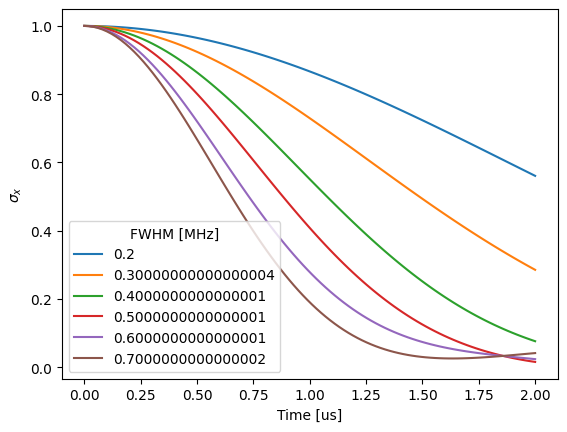

In [15]:
ds.sigma_x_exp.plot(hue="detuning_MHz_FWHM");

## Multiprocessing using dask

`xarray` offers also a native way of multiprocessing using `dask`. It works less intuitive then my wrapper and has a much larger overhead so usually is slower that my wrapper, but allows for much more complicated features such as, larger than memory arrays, lazy evaluation, multithreading and multiprocessing and distributed computing.

To speed this up we can use `dask` arrays which can do multiprocessing.
For this we need to chuck the data in parts that we want to run at once, e.g.


In [16]:
ds.detuning_hz.chunk(50)

<xarray.DataArray 'detuning_hz' (detuning_MHz_FWHM: 6, mc: 1000)> Size: 48kB
dask.array<xarray-<this-array>, shape=(6, 1000), dtype=float64, chunksize=(6, 50), chunktype=numpy.ndarray>
Coordinates:
  * detuning_MHz_FWHM  (detuning_MHz_FWHM) float64 48B 0.2 0.3 0.4 0.5 0.6 0.7
Dimensions without coordinates: mc

In [17]:
from dask.diagnostics import ProgressBar

You cannot call the `chunk` directly on a coordinate of a dataset. Therefore you first need to pass it to `xr.DataArray`

In [18]:
number_of_mc_realizations = 1000
detuning_MHz_mean = 0
detuning_MHz_sigma = 0.5
ds = xr.Dataset()
ds["time_us"] = np.linspace(0, 2, 100)
ds.time_us.attrs = {"long_name": "Time", "units": "us"}
ds["time_s"] = ds.time_us * US_TO_S
ds['sigma_MHz'] = np.arange(0.2, 0.82, 0.1)
ds.sigma_MHz.attrs = {"long_name": "Sigma", "units": "MHz"}
ds["detuning_Mhz"] = xr.apply_ufunc(
    np.random.normal,
    detuning_MHz_mean, 
    ds.sigma_MHz,
    number_of_mc_realizations,
    output_core_dims=[['mc']],
    vectorize=True)
ds.detuning_Mhz.attrs = {"long_name": "Detuning", "units": "MHz"}
ds["detuning_hz"] = ds.detuning_Mhz * MHZ_TO_HZ
ds["sigma_x"] = xrmod.apply_ufunc(
    ramsey,
    ds.time_s,
    xr.DataArray(ds.detuning_hz).chunk(50),
    input_core_dims=[["time_us"], []],
    output_core_dims=[["time_us"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
)
ds.sigma_x.attrs = {"long_name": r"$\sigma_x$"}
ds["sigma_x_exp"] = ds.sigma_x.mean("mc")
ds.sigma_x_exp.attrs = {"long_name": r"$\sigma_x$"}
with ProgressBar():
    ds = ds.compute(scheduler="processes")
ds

[########################################] | 100% Completed | 17.26 s


<xarray.Dataset> Size: 6MB
Dimensions:       (time_us: 100, sigma_MHz: 7, mc: 1000)
Coordinates:
  * time_us       (time_us) float64 800B 0.0 0.0202 0.0404 ... 1.96 1.98 2.0
  * sigma_MHz     (sigma_MHz) float64 56B 0.2 0.3 0.4 0.5 0.6 0.7 0.8
Dimensions without coordinates: mc
Data variables:
    time_s        (time_us) float64 800B 0.0 2.02e-08 ... 1.98e-06 2e-06
    detuning_Mhz  (sigma_MHz, mc) float64 56kB -0.1713 0.2689 ... 0.8699 -0.1243
    detuning_hz   (sigma_MHz, mc) float64 56kB -1.713e+05 ... -1.243e+05
    sigma_x       (sigma_MHz, mc, time_us) float64 6MB 1.0 0.9998 ... 0.009199
    sigma_x_exp   (sigma_MHz, time_us) float64 6kB 1.0 0.9997 ... 0.01894 0.0191

Which is faster than running it on a single core, but not as fast as my wrapper.